In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from numba import jit, njit
from scipy.stats import  t

In [3]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    # Wiener Process by default
    # use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    @staticmethod
    @njit
    def EulerDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        xs = x0 + bxt(x0, t0, params) * (t - t0)
        sigma2 = sigmaxt(x0, t0, params)**2 * (t - t0)

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def OzakiDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        K = 1 / (t - t0) * np.log(1 + bxt(x0, t0, params) / (x0 * bxt_x(x0, t0, params)) * (np.exp(bxt_x(x0, t0, params) * (t - t0)) - 1))
        E = x0 + bxt(x0, t0, params) / bxt_x(x0, t0, params) * (np.exp(bxt_x(x0, t0, params) * (t - t0)) - 1)
        V = sigmaxt(x0, t0, params)**2 / (2 * K) * (np.exp(2 * K * (t - t0)) - 1)

        xs = E
        sigma2 = V

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def ShojiOzakiDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        L = bxt_x(x0, t0, params)

        #safe division
        if L == 0:
            L = L + 0.001

        M = sigmaxt(x0, t0, params)**2 / 2 * bxt_xx(x0, t0, params) + bxt_t(x0, t0, params)

        A = 1 + bxt(x0, t0, params) / (x0 * L) * (np.exp(L * (t - t0)) - 1) + M / (x0 * L**2) * \
            (np.exp(L * (t - t0)) - 1 - L * (t - t0))
        B = sigmaxt(x0, t0, params)**2 * 1/(2 * L) * (np.exp(2 * L * (t - t0)) - 1)

        xs = A * x0
        sigma2 = B

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def KesslerDensity(x, t, x0, t0, params, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        E = x0 + bxt(x0, t0, params) * (t - t0) + (bxt(x0, t0, params) * bxt_x(x0, t0, params) + 1/2 * \
            sigmaxt(x0, t0, params)**2 * bxt_xx(x0, t0, params)) * 1/2 * (t - t0)**2
        V = x0**2 + (2 * bxt(x0, t0, params) * x0 + sigmaxt(x0, t0, params)**2 ) * (t - t0)\
            + (2 * bxt(x0, t0, params) * (bxt_x(x0, t0, params) * x0 + bxt(x0, t0, params) + \
                sigmaxt(x0, t0, params) * sigmaxt_x(x0, t0, params))\
            + sigmaxt(x0, t0, params)**2 * (bxt_xx(x0, t0, params) * x0 + 2 * bxt_x(x0, t0, params) +\
                sigmaxt_x(x0, t0, params)**2 + sigmaxt(x0, t0, params) * sigmaxt_xx(x0, t0, params))) * (t - t0)**2 / 2 - E**2

        xs = E

        #safe division
        if V == 0:
            V = V + 0.001

        sigma2 = V

        return -1/2 * np.log(2 * np.pi * sigma2) - (x - xs)**2 / (2 * sigma2)

    @staticmethod
    @njit
    def MLogLik(params, t_data, x_data, density, bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t):
        Nt = len(x_data)
        Nx = len(x_data[0])
        log_data = np.zeros(Nx)
        for k in range(0, Nx):
            m_log_lik = 0
            for j in range(1, Nt):
                m_log_lik += density(x_data[j][k], t_data[j], x_data[j - 1][k], t_data[j - 1], params,
                                     bxt, bxt_x, bxt_xx, sigmaxt, sigmaxt_x, sigmaxt_xx, bxt_t)
            log_data[k] = m_log_lik

        res = -np.mean(log_data)
        return res

    def EulerEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.EulerDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def OzakiEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.OzakiDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def ShojiOzakiEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.ShojiOzakiDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

    def KesslerEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.KesslerDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta, mu, sigma]

    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * (params[1] - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)
    
    def EulerEstimation(self, t_data, x_data):
        x0 = np.ones(len(self.params))
        accuracy = 1e-8

        min_result = minimize(self.MLogLik,
                              x0 = x0,
                              args=(t_data, x_data, self.EulerDensity,
                              self.bxt, self.bxt_x, self.bxt_xx, self.sigmaxt, self.sigmaxt_x, self.sigmaxt_xx,
                              self.bxt_t),
                              method = 'L-BFGS-B',
                              options={'ftol': accuracy, 'eps': accuracy})
        return min_result

class CKLSprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * x**params[3]

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * params[3] * x**(params[3] - 1)

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return params[2] * params[3] * (params[3] - 1) * x**(params[3] - 2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

class Task5process(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * t * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[1] * x

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[0] * t

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return params[0] * x

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

class HullWhiteprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] * t * (params[1] * np.sqrt(t) - x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * t

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[0] * t

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return params[0] * params[1] * 3/2 * np.sqrt(t)

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

Task 1. Evaluate the conditional density of the Ornstein-Uhlenbeck process
$$dX_t = (3-X_t)dt+2dW_t, \quad X_0=1, \quad %\theta=(1, 3, 2), \quad
N=100000,
\quad \Delta=1$$ and calculate the
maximum likelihood estimation.  

In [4]:
Nx = 100000
Nt = 300

T = 1

params_OU = np.array([3, 1, 2])

x0 = 1
init_state = x0 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.EulerSolution()

In [5]:
OUp.EulerEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -221.94613140832425
        x: [ 3.001e+00  9.946e-01  2.000e+00]
      nit: 17
      jac: [ 2.473e-04  3.496e-04 -4.462e-04]
     nfev: 76
     njev: 19
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [6]:
OUp.ShojiOzakiEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -221.9461313748568
        x: [ 3.016e+00  9.946e-01  2.010e+00]
      nit: 16
      jac: [ 1.904e-04  5.343e-04 -4.235e-04]
     nfev: 84
     njev: 21
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [7]:
OUp.KesslerEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -221.9461300533536
        x: [ 3.016e+00  9.945e-01  2.010e+00]
      nit: 17
      jac: [-2.558e-05  7.105e-05  1.052e-04]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Task. Find the maximum likelihood estimators  numerically
 for Ornstein-Uhlenbeck process
 $$
 dX_t = -\theta_2X_tdt + \theta_3dW_t, \quad \theta=(0, 3, 2), \quad
N=1000, \quad \Delta=1
$$
and compare with explicit estimations

$$
\hat{\theta}_{2,n} = -\frac{1}{\Delta}\log \left(\frac{\sum_{i=1}^n X_{i-1}X_i} {\sum_{i=1}^n X^2_{i-1}}\right),
$$
$$
\hat{\theta}_{3,n} = \sqrt{\frac{2\hat{\theta}_{2,n}}
{n(1 - e^{-2\Delta  \hat{\theta}_{2,n}})}
\sum_{i=1}^n (X_i- X_{i-1} e^{-\Delta \hat{\theta}_{2, n}})^2}.
$$

In [8]:
# TODO explicitly fix theta1 = 0


def theta_2_estimation(n: int, delta: float, x: np.ndarray) -> float:
    a = 0
    b = 0
    for i in range(1, n):
        a += x[i-1] * x[i]
        b += x[i-1] ** 2
    
    return - np.log(a / b) / delta


def theta_3_estimation(n: int, delta: float, x: np.ndarray) -> float:
    theta_2 = theta_2_estimation(n, delta, x)
    a = 0
    for i in range(1, n):
        a += (x[i] - x[i-1]* np.exp(-delta * theta_2))**2
    
    return np.sqrt(2 * theta_2 * a / (n * (1 - np.exp(-2 * delta * theta_2))))

In [9]:
# your code
Nx = 1000
Nt = 1000

T = 1

# theta_2 = 3, mu = 0, theta_3 = 2
params_OU = np.array([3, 0, 2])

x0 = 1
init_state = x0 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.EulerSolution()

In [10]:
euler_params = OUp.EulerEstimation(t_data, x_data_OU)

In [11]:
euler_params.jac

array([6.82121030e-05, 0.00000000e+00, 1.56887837e-03])

In [12]:
x_data_OU.shape

(1001, 1000)

In [13]:
delta = 1.6

theta_2_estimation(Nt, delta, x_data_OU[-1]), theta_3_estimation(Nt, delta, x_data_OU[-1])

(2.1302259780881814, 1.7344644033210044)

In [14]:
euler_params.x

array([ 2.84169737, -0.02496446,  2.00067818])

Task 3. Consider  the Chan-Karolyi-Longstaff-Sanders (CKLS) model
$$
 dX_{t} = (\theta_{1}+\theta_{2} X_{t}) dt + \theta_{3} X_{t}^{\theta_{4}} dW_{t},\qquad X_{0}=2
$$
with $\theta_{1}=1$, $\theta_{2}=2$, $\theta_{3}=0.5$, $\theta_{4}=0.3$.

Use the Euler method and
* generate the sample data $X_{t_i}$ with time step $\Delta t =10^{-4}$,  
* estimate drift and diffusion coefficients,
* compute confidence intervals for all parameters in a fitted SDE.  


In [15]:
Nx = 1
Nt = 10000

T = 1

params_CKLS = np.array([1, 2, 0.5, 0.3])

x0 = 2
init_state = x0 * np.ones(Nx)

CKLSp = CKLSprocess(params_CKLS, T, Nx, Nt, init_state)

t_data, x_data_CKLS = CKLSp.EulerSolution()

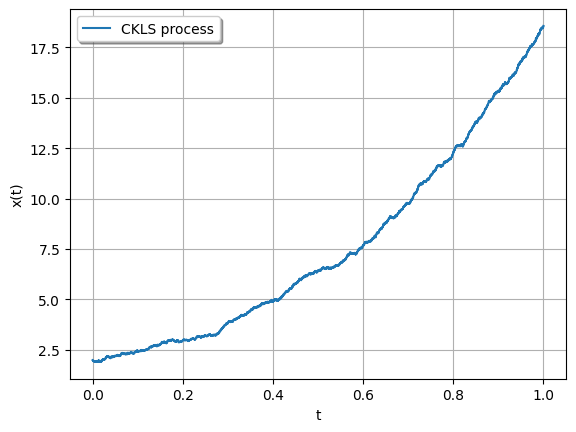

In [16]:
plt.plot(t_data, x_data_CKLS[:,0], label = 'CKLS process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [17]:
CKLSp.EulerEstimation(t_data, x_data_CKLS)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -33367.98272883714
        x: [ 1.117e+00  2.039e+00  5.103e-01  2.882e-01]
      nit: 18
      jac: [ 1.892e-02  2.910e-02  1.186e+00  2.453e+00]
     nfev: 115
     njev: 23
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [18]:
#Confidence intervals
n = 50
result = np.zeros((n, 4))
for k in range(0, n):
    t_data, x_data_CKLS = CKLSp.EulerSolution()
    result[k] = CKLSp.EulerEstimation(t_data, x_data_CKLS).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 4):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = 1.243186947547906 +- 0.3314250023127126 with 95.0% prob
theta1 = 1.9770398778316396 +- 0.044486357387459 with 95.0% prob
theta2 = 0.5019970699006443 +- 0.0032184626272924502 with 95.0% prob
theta3 = 0.29737604323149414 +- 0.003288454558191307 with 95.0% prob


Task 4. Consider the Vasicek model
$$
dX_{t} = \theta_{1} (\theta_{2}- X_{t}) dt + \theta_{3} dW_{t},\qquad X_{0}=5
$$
with $\theta_{1}=3$, $\theta_{2}=2$ and $\theta_{3}=0.5$.

Use the Ozaki method and
*   generate the sample data $X_{t_i}$, time step $\Delta t =10^{-2}$,
*   estimate drift and diffusion coefficients,
*   compute confidence intervals for all parameters in a fitted SDE.

In [19]:
Nx = 1
Nt = 100

T = 1

params_OU = np.array([3, 2, 0.5])

x0 = 5
init_state = x0 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.EulerSolution()

In [20]:
OUp.OzakiEstimation(t_data, x_data_OU)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -166.66547215620275
        x: [ 4.021e+00  2.307e+00  4.586e-01]
      nit: 18
      jac: [ 4.263e-05 -3.411e-05  1.592e-04]
     nfev: 96
     njev: 24
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [21]:
#Confidence intervals
n = 50
result = np.zeros((n, 3))
for k in range(0, n):
    t_data, x_data_OU = OUp.EulerSolution()
    result[k] = OUp.OzakiEstimation(t_data, x_data_OU).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 3):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = 3.265771779072351 +- 0.19695253662289777 with 95.0% prob
theta1 = 2.01703348290463 +- 0.0678986395539958 with 95.0% prob
theta2 = 0.38211515967934767 +- 0.0931912454655657 with 95.0% prob


Task 5. Consider the model
$$
  dX_{t} = a(t)X_{t} dt + \theta_{2}X_{t} dW_{t},\qquad X_{0}=10
$$
with $a(t) = \theta_{1}t$, $\theta_{1}=-2$, $\theta_{2}=0.2$.

Use the Shoji-Ozaki method and:
* generate the sample data $X_{t_i}$ time step $\Delta t =10^{-3}$,  
* estimate drift and diffusion coefficients,
* compute confidence intervals for all parameters in a fitted SDE.

In [22]:
Nx = 1
Nt = 1000

T = 1

params_T5 = np.array([-2, 0.2])

x0 = 5
init_state = x0 * np.ones(Nx)

T5p = Task5process(params_T5, T, Nx, Nt, init_state)

t_data, x_data_T5 = T5p.EulerSolution()

In [23]:
T5p.ShojiOzakiEstimation(t_data, x_data_T5)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -2370.812190044071
        x: [-2.080e+00  2.029e-01]
      nit: 15
      jac: [-1.266e-01  5.339e-02]
     nfev: 87
     njev: 29
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

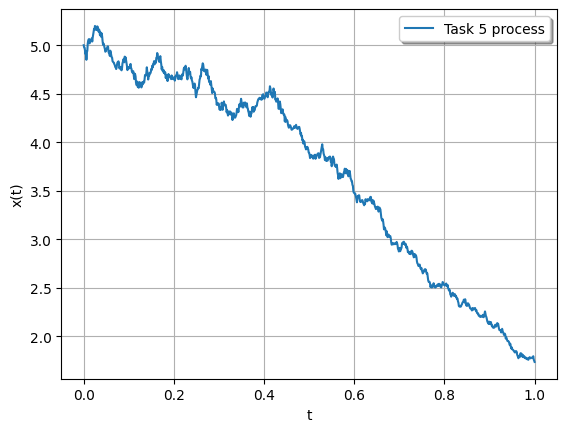

In [24]:
plt.plot(t_data, x_data_T5[:,0], label = 'Task 5 process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [25]:
#Confidence intervals
n = 50
result = np.zeros((n, 2))
for k in range(0, n):
    t_data, x_data_T5 = T5p.EulerSolution()
    result[k] = T5p.ShojiOzakiEstimation(t_data, x_data_T5).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 2):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = -1.9825366319224202 +- 0.09602448381822302 with 95.0% prob
theta1 = 0.1677784740159924 +- 0.0315426699355755 with 95.0% prob


Task 6. Consider the Hull-White (extended Vasicek) model
$$
  dX_{t} = a(t)(b(t)-X_{t}) dt + \sigma(t) dW_{t},\qquad X_{0}=2
$$
with $a(t) = \theta_{1}t$, $b(t)=\theta_{2}\sqrt{t}$, the volatility depends on time $\sigma(t)=\theta_{3}t$.

Generate sample data of $X_t$ with time step $\Delta t =10^{-3}$ and $\theta_{1}=3$, $\theta_{2}=1$ and $\theta_{3}=0.3$, then
use the Kessler method and:
*   estimate drift and diffusion coefficients,
*   compute confidence intervals for all parameters in a fitted SDE.

In [26]:
Nx = 1
Nt = 100

T = 1

params_HW = np.array([3, 1, 0.3])

x0 = 2
init_state = x0 * np.ones(Nx)

HWp = HullWhiteprocess(params_HW, T, Nx, Nt, init_state)

t_data, x_data_HW = HWp.EulerSolution()

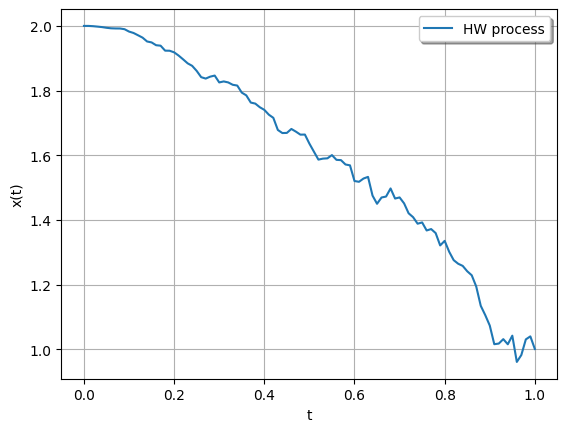

In [27]:
plt.plot(t_data, x_data_HW[:,0], label = 'HW process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [28]:
HWp.KesslerEstimation(t_data, x_data_HW)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -303.9087368538385
        x: [ 2.370e+00  7.362e-01  3.073e-01]
      nit: 15
      jac: [ 5.377e-02  6.602e-02  7.076e-02]
     nfev: 152
     njev: 38
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Task. Take a process from previous tasks and approximation method, find the solution, compute confidence intervals, and compare results with baseline.

Plot the graph and table.

Задания по вариантам
1. Байков Илья Павлович OU + Kessler
1. Гонгапшев Астемир Султанович CKLS + Shoji-Ozaki
1. Кудинкина Екатерина Андреевна CKLS + Kessler
1. Кулига Андрей Владимирович Vasicek + Euler
1. Мартыненко Александр Станиславович Vasicek + Shoji-Ozaki
1. Мироманов Даниил Борисович Vasicek + Kessler
1. Паршаков Никита Сергеевич extended Vasicek + Euler
1. Петренко Влада Витальевна extended Vasicek + Ozaki
1. Тумачев Серафим Дмитриевич extended Vasicek + Shoji-Ozaki
1. Хубиев Касымхан Юсуфович model 5 + Euler
1. Ширяева Софья Игоревна model 5 + Ozaki
1. Якунин Сергей Александрович model 5 + Kessler
1. Трофимов Яков Георгиевич CKLS + Ozaki


# Ann and Gao (inverse of Feller's square root) model

satisfies the following SDE:

$$dX_t = X_t(\theta_1 - (\theta_3^3 - \theta_1\theta_2)X_t)dt + \theta_3X_t^{\frac{3}{2}}dW_t$$

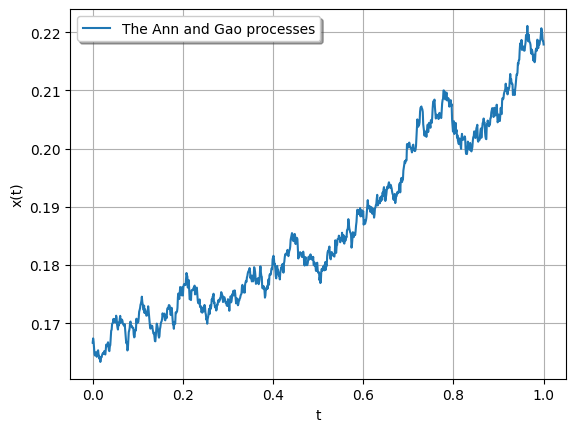

In [76]:
class AnnGaoProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):

        try:
            super().__init__(params, T, Nx, Nt, init_state)

            # # params = [theta1, theta2, theta3]
            # theta1, theta2, theta3 = self.params
            # self.bxt = lambda x: x * (theta1 - (theta3**3 - theta1 * theta2) * x)
            # self.sigmaxt = lambda x: x ** 1.5 * theta3
        except AssertionError:
            print(f'all the input params must of the type float, but {params} where given')

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        # return params[0] * t * x
        return x * (params[0] - (params[2]**3 - params[0]*params[1]) * x)

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * x ** 1.5 

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return (params[0] - 2 * (params[2]**3 - params[0]*params[1]) * x)

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 1.5 * params[2] * x ** .5

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0
    
    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return -2 * (params[2]**3 - params[0]*params[1])

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return .75 * params[2] * x ** (-.5)

    def DefaultInitState(self):
        return self.params[0] / (self.params[2] - self.params[0] * self.params[1]) * np.ones(self.Nx)
        # return self.params[0] / self.params[1] * np.ones(self.Nx)

    def sampler_init_state(self):
        return self.params[0] / (self.params[2] - self.params[0] * self.params[1]) * np.ones(self.Nx)
    
# Parameters
theta1 = .1
theta2 = .6
theta3 = .3

x0 = 0 
Nx = 1
Nt = 1000
T = 1.0 

params = [theta1, theta2, theta3]

AnnGao = AnnGaoProcess(params, T, Nx, Nt)
t_data, x_data_AG = AnnGao.EulerSolution()
plt.plot(t_data, x_data_AG, label = 'The Ann and Gao processes')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

In [80]:
AnnGao.EulerEstimation(t_data, x_data_AG)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -5713.1674912133285
        x: [ 2.025e-01  8.740e-01  3.167e-01]
      nit: 12
      jac: [-2.001e-03  1.637e-02  1.382e-02]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [78]:
#Confidence intervals
n = 50
result = np.zeros((n, 3))
for k in range(0, n):
    t_data, x_data_AG = AnnGao.EulerSolution()
    result[k] = AnnGao.EulerEstimation(t_data, x_data_AG).x


alpha = 0.05
q = t.ppf(1-alpha/2, n - 1)
for i in range(0, 3):
    m = np.mean(result[:,i])
    v = np.std(result[:,i], ddof=1)
    print(f"theta{i} = {m} +- {v * q / np.sqrt(n)} with {100 - alpha * 100}% prob")

theta0 = 0.09800270528549415 +- 0.024329585284866607 with 95.0% prob
theta1 = 0.8796429099727774 +- 0.006203057149864361 with 95.0% prob
theta2 = 0.023412688091585795 +- 0.08633213664476544 with 95.0% prob
